In [1]:
import geopandas as gpd # for geospatial data handling
import pandas as pd
import osmnx as ox # for handling data from OpenStreetMap (osm) with the help of networkX (nx)
import contextily as cx # for plotting
import matplotlib.pyplot as plt # for plotting
from pyproj import CRS # for more advanced CRS modifications and transformations
from shapely.geometry import Polygon
import numpy as np
import pandana 
import os

In [8]:
#amenities_with_neighborhood.to_file("amenities_with_neighborhood.geojson", driver='GeoJSON')
amenities_with_neighborhood = gpd.read_file('/Users/caro/Desktop/SPRING24/GDS/PROJECT/GDS_project/dataframes/amenities_with_neighborhood.geojson')

In [7]:
neighbourhoods = list(amenities_with_neighborhood['Arrondissement'].unique())[:-1]
neighbourhoods = [neighborhood + ', Montreal, Canada' for neighborhood in neighbourhoods]

In [10]:
place = 'Montreal, Canada'
# Get all the "fresh food" stores on OSM within the study site
tags = {'amenity': ['restaurant', 'cafe']}
amenities = ox.features_from_place(place, tags=tags)
amenities = amenities.to_crs('EPSG:25832')
# Some amenities might be polygons, but we need them as points, so let's extract the centroids from the amenities' geometries
centroids = amenities.centroid

In [26]:
# RUN ONLY ONCE TO SAVE THE GRAPHS - ALREADY DONE

graphs = {}

# specify parameters for the analysis
walk_time = 15  # max walking horizon in minutes
walk_speed = 5  # km per hour
walk_time_sec = walk_time * 60 # We need the time in seconds to match how travel time is calculated in OSMnx

# Loop through the neighborhoods
for neighborhood in neighbourhoods:
    # Create a graph for the current neighborhood
    G_walk_neighborhood = ox.graph_from_place(neighborhood, network_type='walk') # type of transportation is set here

    for u, v, data in G_walk_neighborhood.edges(data=True):
        data['speed_kph'] = walk_speed
    G_walk_neighborhood = ox.add_edge_travel_times(G_walk_neighborhood) # this computes the travel time in seconds based on the 'speed_kph' column

    ox.save_graphml(G_walk_neighborhood, f"/Users/caro/Desktop/SPRING24/GDS/PROJECT/graphs/G_walk_{neighborhood}.graphml") # save graph per neighbourhood   
    # Store the graph in the dictionary using the neighborhood name as the key
    graphs[neighborhood] = G_walk_neighborhood

KeyboardInterrupt: 

In [2]:
graphs = {}
graphs_dir = '/Users/caro/Desktop/SPRING24/GDS/PROJECT/graphs'
for file_name in os.listdir(graphs_dir):
    if file_name.endswith(".graphml"):
        neighborhood = file_name.replace("G_walk_", "").replace(".graphml", "")
        file_path = os.path.join(graphs_dir, file_name)
        G_walk_neighborhood = ox.load_graphml(file_path)
        graphs[neighborhood] = G_walk_neighborhood

In [4]:
pandanas = {}
# Build Pandana network for each neighborhood
for neighborhood, graph in graphs.items():
    graph = ox.project_graph(graph, to_crs='EPSG:25832')
    nodes = ox.graph_to_gdfs(graph, edges=False)[['x', 'y']]
    edges = ox.graph_to_gdfs(graph, nodes=False).reset_index()[['u', 'v', 'travel_time']]

    network = pandana.Network(node_x=nodes['x'],
                            node_y=nodes['y'], 
                            edge_from=edges['u'],
                            edge_to=edges['v'],
                            edge_weights=edges[['travel_time']])
    
    pandanas[neighborhood] = network

Generating contraction hierarchies with 4 threads.
Setting CH node vector of size 9639
Setting CH edge vector of size 30838
Range graph removed 31100 edges of 61676
. 10% . 20% . 30% . 40% . 50% . 60% . 70% . 80% . 90% . 100%
Generating contraction hierarchies with 4 threads.
Setting CH node vector of size 14281
Setting CH edge vector of size 46136
Range graph removed 46506 edges of 92272
. 10% . 20% . 30% . 40% . 50% . 60% . 70% . 80% . 90% . 100%
Generating contraction hierarchies with 4 threads.
Setting CH node vector of size 14970
Setting CH edge vector of size 48624
Range graph removed 48876 edges of 97248
. 10% . 20% . 30% . 40% . 50% . 60% . 70% . 80% . 90% . 100%
Generating contraction hierarchies with 4 threads.
Setting CH node vector of size 2588
Setting CH edge vector of size 8290
Range graph removed 8386 edges of 16580
. 10% . 20% . 30% . 40% . 50% . 60% . 70% . 80% . 90% . 100%
Generating contraction hierarchies with 4 threads.
Setting CH node vector of size 9720
Setting C

In [90]:
#G_walk_anjou = graphs['Anjou, Montreal, Canada'] # access one graph
#pandana_anjou = pandanas["Specific Neighborhood"] # access one pandana network

In [6]:
walk_time = 15  # max walking horizon in minutes
walk_speed = 5  # km per hour
walk_time_sec = walk_time * 60 # We need the time in seconds to match how travel time is calculated in OSMnx

In [11]:
walking_distances = {}  # Dictionary to store walking distances

for neighborhood, pandana in pandanas.items():
    pandana.set_pois(category='restaurant', # amenity set here
                     maxdist=walk_time_sec,
                     maxitems=3,
                     x_col=centroids.x, 
                     y_col=centroids.y)
    
    distances = pandana.nearest_pois(distance=walk_time_sec,
                                      category='restaurant', # amenity set here
                                      num_pois=3)
    
    distances['travel_time'] = distances[1] / 60
    walking_distances[neighborhood] = distances

/Users/caro/Library/Python/3.10/lib/python/site-packages/pandana/network.py:753: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  elif isinstance(maxitems, type(pd.Series())):
/Users/caro/Library/Python/3.10/lib/python/site-packages/pandana/network.py:761: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  elif isinstance(maxdist, type(pd.Series())):


               1    2    3  travel_time
osmid                                  
26232893      33  185  474            0
11495723273   32  175  463            0
11495723274   40  193  481            0
11495717756    3  170  492            0
30914720     292  307  451            4
...          ...  ...  ...          ...
11862799553  821  900  900           13
11862799552  834  900  900           13
11862799555  834  900  900           13
11862799564  828  900  900           13
11862799568  842  900  900           14

[9639 rows x 4 columns]


/Users/caro/Library/Python/3.10/lib/python/site-packages/pandana/network.py:753: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  elif isinstance(maxitems, type(pd.Series())):
/Users/caro/Library/Python/3.10/lib/python/site-packages/pandana/network.py:761: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  elif isinstance(maxdist, type(pd.Series())):


               1    2    3  travel_time
osmid                                  
29237095      12   12   12            0
10790652823    7    7    7            0
10790652826    6    6    6            0
10790652819   18   18   18            0
10790652813   17   17   17            0
...          ...  ...  ...          ...
11787344224  289  420  475            4
11844819144  429  438  442            7
11844819145  438  447  451            7
11844819150  456  465  469            7
11847262969    0   39   39            0

[14281 rows x 4 columns]


/Users/caro/Library/Python/3.10/lib/python/site-packages/pandana/network.py:753: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  elif isinstance(maxitems, type(pd.Series())):
/Users/caro/Library/Python/3.10/lib/python/site-packages/pandana/network.py:761: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  elif isinstance(maxdist, type(pd.Series())):


               1    2    3  travel_time
osmid                                  
29794121      55  105  105            0
11168601442   61  101  101            1
11168001222   21   71   71            0
11168001017    6    8   15            0
29794123      12   13   13            0
...          ...  ...  ...          ...
11813700311   40   51   57            0
11813700332   48   49   53            0
11813700331   35   46   63            0
11824785378  159  159  164            2
11845300180  529  628  660            8

[14970 rows x 4 columns]
               1    2    3  travel_time
osmid                                  
29239079     104  174  174            1
3199024093    97  168  168            1
3215289251   112  177  177            1
3215289252   105  184  184            1
29795235      97   97   97            1
...          ...  ...  ...          ...
11619137891    4    4    4            0
11619137892    4    4   13            0
11619137899    4    4   14            0
11807651980  4

/Users/caro/Library/Python/3.10/lib/python/site-packages/pandana/network.py:753: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  elif isinstance(maxitems, type(pd.Series())):
/Users/caro/Library/Python/3.10/lib/python/site-packages/pandana/network.py:761: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  elif isinstance(maxdist, type(pd.Series())):
/Users/caro/Library/Python/3.10/lib/python/site-packages/pandana/network.py:753: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  elif isinstance(maxitems, type(pd.Series())):
/Users/caro/Library/Python/3.10/lib/python/site-packages/pandana/network.py:761: FutureWarning: The default dtype for empty Series 

               1    2    3  travel_time
osmid                                  
31703077      41   45   97            0
31703543      51   55   88            0
7164229665    44   51  103            0
7164229667    35   39  103            0
7164229666    35   40   89            0
...          ...  ...  ...          ...
11829040473  126  132  154            2
11829040474  131  136  159            2
11829040481  106  111  133            1
11829040482  110  114  137            1
11829040550  168  176  188            2

[9720 rows x 4 columns]


/Users/caro/Library/Python/3.10/lib/python/site-packages/pandana/network.py:753: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  elif isinstance(maxitems, type(pd.Series())):
/Users/caro/Library/Python/3.10/lib/python/site-packages/pandana/network.py:761: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  elif isinstance(maxdist, type(pd.Series())):


               1    2    3  travel_time
osmid                                  
29217072      79  121  203            1
7137077967    84  126  198            1
246283586     69  112  213            1
7137077966    73  115  198            1
9656011731    96  138  219            1
...          ...  ...  ...          ...
11753569215  692  755  900           11
11753569225  689  751  900           11
11753569227  659  722  900           10
11753569230  697  759  900           11
11788921813  356  407  418            5

[12319 rows x 4 columns]
               1    2    3  travel_time
osmid                                  
32659924     184  184  220            3
10905762612  175  183  183            2
11069996266  188  188  216            3
1411570399   154  154  188            2
4518898501   152  152  192            2
...          ...  ...  ...          ...
11645781784   67   67   67            1
11645781727   53   53   53            0
11645781756  389  389  389            6
11645781805  2

/Users/caro/Library/Python/3.10/lib/python/site-packages/pandana/network.py:753: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  elif isinstance(maxitems, type(pd.Series())):
/Users/caro/Library/Python/3.10/lib/python/site-packages/pandana/network.py:761: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  elif isinstance(maxdist, type(pd.Series())):
/Users/caro/Library/Python/3.10/lib/python/site-packages/pandana/network.py:753: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  elif isinstance(maxitems, type(pd.Series())):
/Users/caro/Library/Python/3.10/lib/python/site-packages/pandana/network.py:761: FutureWarning: The default dtype for empty Series 

               1    2    3  travel_time
osmid                                  
224886238    348  751  900            5
596644170    547  900  900            9
4502353385   151  554  900            2
224911443      9  412  429            0
8875463868     0  402  438            0
...          ...  ...  ...          ...
11662037419  223  223  223            3
11662037462  306  306  306            5
11662037420  244  244  244            4
11662037457  311  311  311            5
11662037426  206  206  206            3

[3200 rows x 4 columns]
               1    2    3  travel_time
osmid                                  
218198366      8    8    8            0
11627155112   16   16   16            0
11627155108    0    0    0            0
3199246524    15   15   15            0
11627155086   12   12   12            0
...          ...  ...  ...          ...
11841979295  319  329  660            5
11842005806  541  615  726            9
11844962856  258  311  589            4
11862788405  49

/Users/caro/Library/Python/3.10/lib/python/site-packages/pandana/network.py:753: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  elif isinstance(maxitems, type(pd.Series())):
/Users/caro/Library/Python/3.10/lib/python/site-packages/pandana/network.py:761: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  elif isinstance(maxdist, type(pd.Series())):
/Users/caro/Library/Python/3.10/lib/python/site-packages/pandana/network.py:753: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  elif isinstance(maxitems, type(pd.Series())):
/Users/caro/Library/Python/3.10/lib/python/site-packages/pandana/network.py:761: FutureWarning: The default dtype for empty Series 

               1    2    3  travel_time
osmid                                  
116415771    130  558  625            2
4742318344   136  552  619            2
4198102084   121  554  621            2
9801597968   135  561  628            2
4742318345   123  565  631            2
...          ...  ...  ...          ...
11778087348  611  900  900           10
11778087325  560  900  900            9
11778087320  616  900  900           10
11778087329  587  900  900            9
11778087349  613  900  900           10

[3795 rows x 4 columns]


/Users/caro/Library/Python/3.10/lib/python/site-packages/pandana/network.py:753: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  elif isinstance(maxitems, type(pd.Series())):
/Users/caro/Library/Python/3.10/lib/python/site-packages/pandana/network.py:761: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  elif isinstance(maxdist, type(pd.Series())):


               1    2    3  travel_time
osmid                                  
31630568     164  178  212            2
3346043819   170  171  205            2
7340342279   167  173  207            2
3346043818   162  181  215            2
7340342283   157  183  213            2
...          ...  ...  ...          ...
11833738031  223  234  234            3
11833738033  208  252  252            3
11833738065  128  128  128            2
11833781982  138  138  138            2
11833781979  131  131  131            2

[10411 rows x 4 columns]


/Users/caro/Library/Python/3.10/lib/python/site-packages/pandana/network.py:753: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  elif isinstance(maxitems, type(pd.Series())):
/Users/caro/Library/Python/3.10/lib/python/site-packages/pandana/network.py:761: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  elif isinstance(maxdist, type(pd.Series())):


               1    2    3  travel_time
osmid                                  
26232418       9    9   45            0
1653821632     4   13   41            0
11322670493    3   14   40            0
11340718245    4   12   49            0
11340718237    5   13   41            0
...          ...  ...  ...          ...
11812989325   43   80   86            0
11812989337    0  117  123            0
11815941191  232  272  273            3
11815941198  206  245  247            3
11818791577  159  218  218            2

[8890 rows x 4 columns]
               1    2    3  travel_time
osmid                                  
109828183     22   40   40            0
9674454095    27   33   33            0
9674454173    28   48   48            0
109837398     11   46   46            0
9674454153    16   41   41            0
...          ...  ...  ...          ...
11748337309  345  900  900            5
11748337300  446  900  900            7
11748337301  417  900  900            6
11748337314  29

/Users/caro/Library/Python/3.10/lib/python/site-packages/pandana/network.py:753: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  elif isinstance(maxitems, type(pd.Series())):
/Users/caro/Library/Python/3.10/lib/python/site-packages/pandana/network.py:761: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  elif isinstance(maxdist, type(pd.Series())):
/Users/caro/Library/Python/3.10/lib/python/site-packages/pandana/network.py:753: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  elif isinstance(maxitems, type(pd.Series())):
/Users/caro/Library/Python/3.10/lib/python/site-packages/pandana/network.py:761: FutureWarning: The default dtype for empty Series 

               1    2    3  travel_time
osmid                                  
26232481      28  424  773            0
1931061577    30  426  770            0
1931061700     9  405  791            0
1931061622    42  438  787            0
26232547      30  385  811            0
...          ...  ...  ...          ...
11865999594  345  345  345            5
11865999578  367  367  367            6
11865999592  359  359  359            5
11865999580  349  349  349            5
11865999581  344  344  344            5

[13822 rows x 4 columns]
               1    2    3  travel_time
osmid                                  
224806465    900  900  900           15
595748266    900  900  900           15
292449185    900  900  900           15
320621114    864  900  900           14
224806468    701  755  900           11
...          ...  ...  ...          ...
11862981553  900  900  900           15
11862999770  900  900  900           15
11862981558  900  900  900           15
11862999775  9

/Users/caro/Library/Python/3.10/lib/python/site-packages/pandana/network.py:753: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  elif isinstance(maxitems, type(pd.Series())):
/Users/caro/Library/Python/3.10/lib/python/site-packages/pandana/network.py:761: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  elif isinstance(maxdist, type(pd.Series())):
/Users/caro/Library/Python/3.10/lib/python/site-packages/pandana/network.py:753: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  elif isinstance(maxitems, type(pd.Series())):
/Users/caro/Library/Python/3.10/lib/python/site-packages/pandana/network.py:761: FutureWarning: The default dtype for empty Series 

               1    2    3  travel_time
osmid                                  
31278805      12   12   12            0
8907284960     3    3    3            0
8907274501     5    5    5            0
1446305531    18   18   18            0
31278809      57  199  265            0
...          ...  ...  ...          ...
11549689872  122  197  237            2
11549998361  674  900  900           11
11598677402  250  250  250            4
11598677404  303  303  303            5
11716674267  860  860  860           14

[16731 rows x 4 columns]
               1    2    3  travel_time
osmid                                  
224911407    351  351  351            5
224911513    340  340  340            5
534470727    360  360  360            6
2971983675   411  411  411            6
289283212    187  187  187            3
...          ...  ...  ...          ...
11416179099    0   27  220            0
11416157301   66   88  154            1
11416157302   78   99  152            1
11416157332  1

/Users/caro/Library/Python/3.10/lib/python/site-packages/pandana/network.py:753: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  elif isinstance(maxitems, type(pd.Series())):
/Users/caro/Library/Python/3.10/lib/python/site-packages/pandana/network.py:761: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  elif isinstance(maxdist, type(pd.Series())):
/Users/caro/Library/Python/3.10/lib/python/site-packages/pandana/network.py:753: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  elif isinstance(maxitems, type(pd.Series())):
/Users/caro/Library/Python/3.10/lib/python/site-packages/pandana/network.py:761: FutureWarning: The default dtype for empty Series 

               1    2    3  travel_time
osmid                                  
32662002     808  900  900           13
8540714637   804  900  900           13
8540714635   801  900  900           13
8540714636   818  900  900           13
32662023     670  900  900           11
...          ...  ...  ...          ...
11645973591  807  807  807           13
11647267752  767  767  767           12
11647267753  768  768  768           12
11647267755  807  807  807           13
11647267758  807  807  807           13

[6417 rows x 4 columns]


In [21]:
G_walk_anjou = graphs['Anjou, Montreal, Canada'] # access one graph
pandana_anjou = pandanas['Anjou, Montreal, Canada'] # access one pandana network
distances_anjou = walking_distances['Anjou, Montreal, Canada']

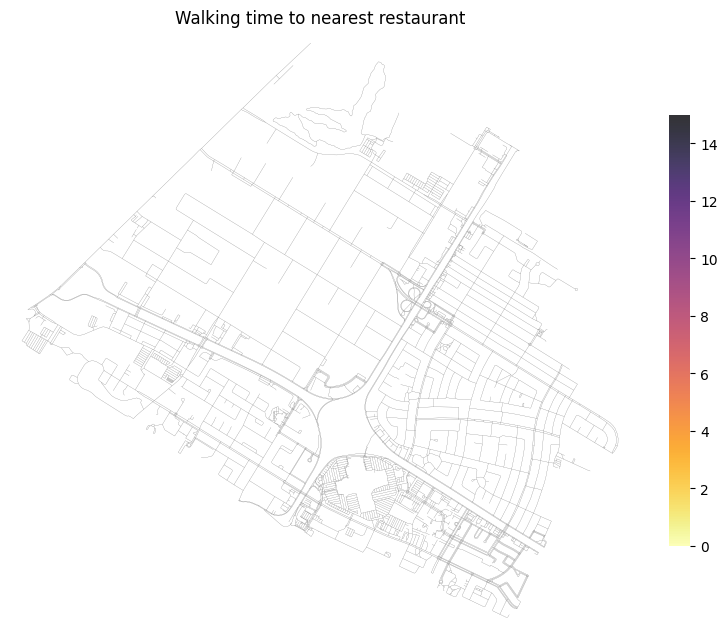

In [29]:
fig, ax = plt.subplots(figsize=(10, 8))

# Plot distance to nearest amenity from each node
ox.plot_graph(G_walk_anjou, ax=ax, node_size=0, edge_linewidth=0.1,
                        edge_color='gray', show=False, close=False)

sc = ax.scatter(x=pandana_anjou.nodes_df['x'],
                y=pandana_anjou.nodes_df['y'], 
                c=distances_anjou['travel_time'], # column to plot (distance to nearest store)
                s=10, # size
                cmap='inferno_r',
                edgecolors='none',
                alpha=0.8)

ax.set_title('Walking time to nearest restaurant')
plt.colorbar(sc, shrink=0.7).outline.set_edgecolor('none')